In [56]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import linmix
from astropy.table import Table
import astropy.io.ascii as ascii
from lifelines import KaplanMeierFitter
from matplotlib import rc
from matplotlib.ticker import MultipleLocator

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%matplotlib inline    # see the plots in notebook
#%matplotlib qt5      # see the plots in an external window


UsageError: unrecognized arguments: # see the plots in notebook


Reading datas

In [57]:
Tab=Table.read("Table.fit")      #Taurus fluxes and disk mass Tab
Tab_Mass=Table.read("Table_Mass.fit")   #Taurus stellar masses (2-3 models) Tab

#Choose to do the analysis on Fmm vs M* or Mdisk vs M*

#n=1     #Fmm
n=2     #Mdisk

if n==2:
    T='20'   # T=20 K constant dust Temperature
#    T='var'  # variable dust Temperature with luminosity

In [17]:
#Introduction of variable delta --> 
#if delta is True we have an observed data, if it is False we have an upper limit.

delta=Tab['l']!='<'            #observed sources
notdelta = np.logical_not(delta)       #upperlimits

In [18]:
######################################
#        x and y data           #
#    x for the stellar masses and y for the Fmm or Mdisk data    #

x=Tab['LogM*']        #using Baraffe+98 model
x2=Tab_Mass['LogM*2']     #using D'antonaMazzitelli      model
x3=Tab_Mass['LogM*3']     #using Siess+00 model

if n==1:
    y=np.log10(Tab['F1_3'])
if n==2:
    if T=='var':
        y=Tab['LogMdisk']            # Md with T variable in Solar Mass
    if T=='20':
        y=Tab['LogM20disk']         # Md with T constant in Solar Mass

############################################
#              Errors                #
#    Dp --> superior error bar in lg scale; Dn --> inferior error bar in log scale

    ####errors on star mass (log scale)
Dp_x2=Tab_Mass['bM*_up2']-Tab_Mass['LogM*2']
Dn_x2=Tab_Mass['LogM*2']-Tab_Mass['bM*_lo2']
Dp_x3=Tab_Mass['bM*_up3']-Tab_Mass['LogM*3']
Dn_x3=Tab_Mass['LogM*3']-Tab_Mass['bM*_lo3']
    ####errors on Continuum Flux (log scale)
if n==1:
    Dp_x=Tab['bM*_up']-Tab['LogM*']
    Dn_x=Tab['LogM*']-Tab['bM*_lo']
    Dp_y=np.log10(Tab['F1_3']+Tab['calibF'])-y
    Dn_y=y-np.log10(Tab['F1_3']-Tab['calibF'])
     ####errors on Disk mass (log scal
if n==2:
    Dp_x=Tab['bM*_up']-Tab['LogM*']
    Dn_x=Tab['LogM*']-Tab['bM*_lo']
    if T=='var':
        Dp_y=Tab['Dp_disk']   
        Dn_y=Tab['Dn_disk']  
    if T=='20':
        Dp_y=Tab['Dp_20disk']  
        Dn_y=Tab['Dn_20disk'] 



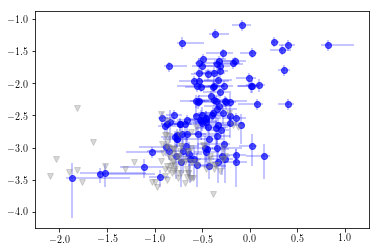

In [19]:
#plot x vs y 
plt.errorbar(x[delta],y[delta],xerr=[Dn_x[delta],Dp_x[delta]], 
             yerr=[Dn_y[delta],Dp_y[delta]], fmt='o', color='blue', alpha=0.3)  
plt.errorbar(x[delta],y[delta], fmt='o', color='blue', alpha=0.5)    
plt.errorbar(x[notdelta],y[notdelta], xerr=0, yerr=0, fmt='v', color='grey',alpha=0.3)    #upperlimits

plt.show()

#### Run the Linmix code for the Bayesian linear regression analysis #

In [20]:
# Define the errors on the variables (The linMix code assumes Gaussian measurement errors)

x2sig=(Dp_x2+Dn_x2)/2.
x3sig=(Dp_x3+Dn_x3)/2.    
xsig=(Dp_x+Dn_x)/2.

ysig=(Dp_y+Dn_y)/2.

In [21]:
####run the linmix on the *DETECTED* object in order to derive the dispersion###

lm_upp_det = linmix.LinMix(x[delta], y[delta], xsig=xsig[delta], ysig=ysig[delta], 
                           delta=delta[delta], K=2, nchains=20)  
#lin regression for Fmm/Md vs M*   
lm_upp_det.run_mcmc(miniter=5000, maxiter=100000, silent=True)    #run the Markov Chain Monte Carlo  

print np.sqrt(lm_upp_det.chain['sigsqr'].mean())

In [22]:
#### set the upper limit uncertanties equal to the dispersion of detections #####
ysig[notdelta]=np.sqrt(lm_upp_det.chain['sigsqr'].mean())

In [24]:
#### run the linmix on the full sample consider the upper limits with 100 MC runs #####
lm_upp = linmix.LinMix(x, y, xsig=xsig, ysig=ysig, delta=delta, K=2, nchains=100)    
lm_upp.run_mcmc(miniter=5000, maxiter=100000, silent=True)    #run the Markov Chain Monte Carlo  

In [25]:
#Considering the mass derived from other preMS models for stellar masses

lm_upp2 = linmix.LinMix(x2, y, xsig=x2sig, ysig=ysig, delta=delta, K=2, nchains=100)    
    # lin regression for Fmm/Md vs (2)M*
lm_upp2.run_mcmc(miniter=5000, maxiter=100000, silent=True)    #run the Markov Chain Monte Carlo


In [26]:
lm_upp3 = linmix.LinMix(x3, y, xsig=x3sig, ysig=ysig, delta=delta, K=2, nchains=100)    
    # lin regression for Fmm/Md vs (3)M*
lm_upp3.run_mcmc(miniter=5000, maxiter=100000, silent=True)    #run the Markov Chain Monte Carlo

In [28]:
####   writing output of regression analysis in an ascii file ####

if n==1:
    ascii.write(lm_upp.chain[['alpha', 'beta', 'sigsqr','mu0', 'usqr', 'wsqr','ximean', 'xisig', 'corr']],
                'Fmm_vs_Ms_Tau.pyout', overwrite=True)
    ascii.write(lm_upp2.chain[['alpha', 'beta', 'sigsqr','mu0', 'usqr', 'wsqr','ximean', 'xisig', 'corr']],
                'Fmm_vs_Ms2_Tau.pyout', overwrite=True)
    ascii.write(lm_upp3.chain[['alpha', 'beta', 'sigsqr','mu0', 'usqr', 'wsqr','ximean', 'xisig', 'corr']],
                'Fmm_vs_Ms3_Tau.pyout', overwrite=True)
if n==2:
    if T=='var':
        ascii.write(lm_upp.chain[['alpha', 'beta', 'sigsqr','mu0', 'usqr', 'wsqr','ximean', 'xisig', 'corr']],
                    'Mdisk_vs_Ms_And13.pyout', overwrite=True)
        ascii.write(lm_upp2.chain[['alpha', 'beta', 'sigsqr','mu0', 'usqr', 'wsqr','ximean', 'xisig', 'corr']],
                    'Mdisk_vs_Ms2_And13.pyout', overwrite=True)
        ascii.write(lm_upp3.chain[['alpha', 'beta', 'sigsqr','mu0', 'usqr', 'wsqr','ximean', 'xisig', 'corr']],
                    'Mdisk_vs_Ms3_And13.pyout', overwrite=True)
    if T=='20':
        ascii.write(lm_upp.chain[['alpha', 'beta', 'sigsqr','mu0', 'usqr', 'wsqr','ximean', 'xisig', 'corr']],
                    'M20disk_vs_Ms_And13.pyout', overwrite=True)
        ascii.write(lm_upp2.chain[['alpha', 'beta', 'sigsqr','mu0', 'usqr', 'wsqr','ximean', 'xisig', 'corr']],
                    'M20disk_vs_Ms2_And13.pyout', overwrite=True)
        ascii.write(lm_upp3.chain[['alpha', 'beta', 'sigsqr','mu0', 'usqr', 'wsqr','ximean', 'xisig', 'corr']],
                    'M20disk_vs_Ms3_And13.pyout', overwrite=True)
        

##### Plot the regression fits. Fmm/Mdisk vs Mstar

In [31]:
#reading output of regression analysis

if n==1:
    pyout1 = ascii.read('Fmm_vs_Ms_Tau.pyout')
    pyout2 = ascii.read('Fmm_vs_Ms2_Tau.pyout')
    pyout3 = ascii.read('Fmm_vs_Ms3_Tau.pyout')
if n==2:
    if T=='var':
        pyout1 = ascii.read('Mdisk_vs_Ms_And13.pyout')
        pyout2 = ascii.read('Mdisk_vs_Ms2_And13.pyout')
        pyout3 = ascii.read('Mdisk_vs_Ms3_And13.pyout')
    if T=='20':
        pyout1 = ascii.read('M20disk_vs_Ms_And13.pyout')
        pyout2 = ascii.read('M20disk_vs_Ms2_And13.pyout')
        pyout3 = ascii.read('M20disk_vs_Ms3_And13.pyout')
        
a1=pyout1['alpha']
b1=pyout1['beta']
s1=np.sqrt(pyout1['sigsqr'])
corr1=pyout1['corr']

a2=pyout2['alpha']
b2=pyout2['beta']
s2=np.sqrt(pyout2['sigsqr'])
corr2=pyout2['corr']

a3=pyout3['alpha']
b3=pyout3['beta']
s3=np.sqrt(pyout3['sigsqr'])
corr3=pyout3['corr']


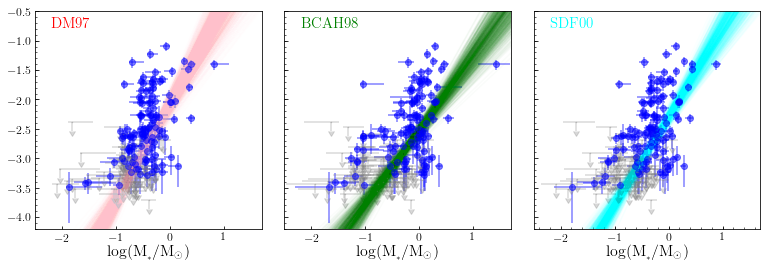

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4) ,sharey=True)
plt.subplots_adjust(wspace=0.1,hspace=0.01)
Ms=(x,x2,x3)
Dp_Ms=(Dp_x,Dp_x2,Dp_x3)
Dn_Ms=(Dn_x,Dn_x2,Dn_x3)
model=('DM97','BCAH98','SDF00')
color=('red','green','cyan')

for j in range(3):
    if n==1:
        ax[j].set_ylim(-3.8,0.1)
        ax[j].text(-2.2, -0.2, model[j],color=color[j], fontsize=15)
    if n==2:
        ax[j].set_ylim(-4.2,-0.5)  
        ax[j].text(-2.2, -0.8, model[j],color=color[j], fontsize=15)
        ax[j].set_xlim(-2.5,1.7)
        ax[j].errorbar(Ms[j][delta],y[delta] ,xerr=[Dn_Ms[j][delta],Dp_Ms[j][delta]],
                       yerr=[Dn_y[delta],Dp_y[delta]], fmt='o', color='blue', alpha=0.5)
        ax[j].errorbar(Ms[j][notdelta],y[notdelta],xerr=[Dn_Ms[j][notdelta],Dp_Ms[j][notdelta]],
                       yerr=0.15,uplims=np.ones(sum(notdelta), dtype=bool), fmt='.', 
                       markersize='1',color='grey', alpha=0.3)
        ax[j].tick_params(axis='both',which='both', direction='in', labelsize=12)
        ax[j].set_xlabel('log(M$_{_*}$/M$_\odot$)', fontsize=16)
        
    
for i in xrange(0, len(a1), 300):
    xs = np.arange(-10,10)
    ys = a1[i] + xs * b1[i]
    ys2 = a2[i] + xs * b2[i]
    ys3 = a3[i] + xs * b3[i]
    ax[0].plot(xs, ys, color='pink', alpha=0.02)
    ax[1].plot(xs, ys2, color='g', alpha=0.02)
    ax[2].plot(xs, ys3, color='cyan', alpha=0.02)

if n==1:
    ax[0].set_ylabel('log(F$_{mm}$/Jy)', fontsize=16)
    plt.suptitle('F$_{mm}$ vs M$_{_*}$ \ (Taurus)', fontsize=20)
if n==2:
    if T=='var':
        ax[0].set_ylabel('log(M$_{disk}$/M$_\odot$)', fontsize=16)
        plt.suptitle('M$_{disk}$ vs M$_{_*}$', fontsize=20)
        if T=='20':
            ax[0].set_ylabel('log(M$_{disk_{20}}$/M$_\odot$)', fontsize=16)
            plt.suptitle('M$_{disk}$ vs M$_{_*}$ at T=20 K', fontsize=20)
            

plt.minorticks_on()
plt.show()
            

In [43]:
print a1.mean(),a1.std()
print b1.mean(),b1.std()
print s1.mean(),s1.std()
print corr1.mean(),corr1.std()
print '-------------'
print a2.mean(),a2.std()
print b2.mean(),b2.std()
print s2.mean(),s2.std()
print corr2.mean(),corr2.std()
print '---------------'
print a3.mean(),a3.std()
print b3.mean(),b3.std()
print s3.mean(),s3.std()
print corr3.mean(),corr3.std()

-2.08076713198 0.110083491588
1.64128948028 0.198403979992
0.651070187133 0.0560241114558
0.684605390352 0.0597350009123
-------------
-2.53021202482 0.0684657808001
1.25617748995 0.139994957163
0.646078070532 0.0551025719225
0.684693756755 0.0473048180685
---------------
-2.3021544799 0.0792472459672
1.50507414961 0.159949169107
0.62863133101 0.0536383900138
0.701699800258 0.0487075139604
